<h1 align=center><font size = 8> <b> Analyze Restaurants in Toronto City </b></font></h1>

<b> Import Required libraries

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


## Retrieve required data

<b> Retrieve wiki page having table contraining postal code information of toronto : 
<a href='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'> Toronto Postal Codes </a>

In [4]:
import urllib.request
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
req = urllib.request.Request(url=url)
f = urllib.request.urlopen(req)
html=f.read()

<b> Create dataframe to store information from wiki

In [5]:
column_names = ['Postal_code', 'Borough', 'Neighborhood']
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods.head()

,Postal_code,Borough,Neighborhood


<b> Extract required infomation from html using Beautiful Soup and add it in dataframe

In [6]:
#from bs4 import BeautifulSoup

soup = BeautifulSoup(html, 'html.parser')
table=soup.find('tbody')
i=0
for row in table :
    if row != '\n' :
        P=row.findChildren()[0].text.replace('\n','')
        B=row.findChildren()[1].text.replace('\n','')
        N=row.findChildren()[2].text.replace('\n','')
        if B != 'Not assigned' and P != "Postal Code"  :
            neighborhoods = neighborhoods.append({'Postal_code':P,'Borough':B,'Neighborhood':N},ignore_index=True)
neighborhoods.head()  

,Postal_code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


<b> Load provided csv file having co-ordinates for Toronto Neighborhood.

In [7]:
print('Loading co-ordinates information from csv file provided')
df_cord=pd.read_csv('Geospatial_Coordinates.csv')
df_cord.head(5)

Loading co-ordinates information from csv file provided


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


<b> Extract co-ordinates for postal codes from df_cord and insert them to 'neighborhoods'

In [8]:
lats=[]
longs=[]
for pc in neighborhoods.Postal_code :
    lats.append(df_cord[df_cord['Postal Code']==pc].Latitude.values[0])
    longs.append(df_cord[df_cord['Postal Code']==pc].Longitude.values[0])

neighborhoods.insert(3,'Lattitude',lats,True)
neighborhoods.insert(4,'Longitude',longs,True)

neighborhoods.drop(['Postal_code'],axis=1,inplace=True)
neighborhoods.head(5)

,Borough,Neighborhood,Lattitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [9]:
neighborhoods.shape

(103, 4)

### <b> Visualize neighborhoods of Toronto on map

<b> Find co-ordinates of Toronto </b>

In [10]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [11]:
# create map of Toronto using latitude and longitude values
map_all = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Lattitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_all)  
    
map_all

### Next step is to get venues in all neighborhoods in Toronto using Forusquare

<b> credentials have been removed <b> <br>
Enter credentials : 

In [56]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


<b> Define functions to a) get venue category for a given row of venue data b) retrieve venue data for neighbourhoods </b> <br>
<b> Then use the functions to retrieve the required data

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    cntr=1
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(cntr,name)
        cntr=cntr+1
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Lattitute', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
# type your answer here
all_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Lattitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

1 Parkwoods
2 Victoria Village
3 Regent Park, Harbourfront
4 Lawrence Manor, Lawrence Heights
5 Queen's Park, Ontario Provincial Government
6 Islington Avenue, Humber Valley Village
7 Malvern, Rouge
8 Don Mills
9 Parkview Hill, Woodbine Gardens
10 Garden District, Ryerson
11 Glencairn
12 West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
13 Rouge Hill, Port Union, Highland Creek
14 Don Mills
15 Woodbine Heights
16 St. James Town
17 Humewood-Cedarvale
18 Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
19 Guildwood, Morningside, West Hill
20 The Beaches
21 Berczy Park
22 Caledonia-Fairbanks
23 Woburn
24 Leaside
25 Central Bay Street
26 Christie
27 Cedarbrae
28 Hillcrest Village
29 Bathurst Manor, Wilson Heights, Downsview North
30 Thorncliffe Park
31 Richmond, Adelaide, King
32 Dufferin, Dovercourt Village
33 Scarborough Village
34 Fairview, Henry Farm, Oriole
35 Northwood Park, York University
36 East Toronto, Broadview North (Old East York)
37 Harbourf

In [17]:
all_venues=all_venues[all_venues['Venue Category']!='Neighborhood']
print(all_venues.shape)

all_venues.head()

(2100, 7)


,Neighborhood,Neighborhood Lattitute,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


<b>  Filter restaurants from all venues

In [18]:
all_venues=all_venues[all_venues['Venue Category'].str.contains('Restaurant|Coffee|Cafe|Pizza|Burger|Bakery|Wine|Food|Bar|Sandwich|Donut|Diner|Café|Breakfast|BBQ')]

In [53]:
all_venues.head()

,Neighborhood,Neighborhood Lattitute,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
5,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
7,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
8,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery


## <b> Data Analysis

In [168]:
# create map of Toronto using latitude and longitude values
map_all = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, ven, cat in zip(all_venues['Venue Latitude'], all_venues['Venue Longitude'], all_venues['Venue'], all_venues['Venue Category']):
    label = '{}, {}'.format(ven,cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_all)  
    
map_all

<b> 1. Number of venues in each neighborhood

In [151]:
venues_count_neighborhood=all_venues.groupby('Neighborhood').count().sort_values(by='Venue',ascending=False)
venues_count_neighborhood

,Neighborhood Lattitute,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Commerce Court, Victoria Hotel",63,63,63,63,63,63
"First Canadian Place, Underground city",61,61,61,61,61,61
"Toronto Dominion Centre, Design Exchange",53,53,53,53,53,53
Stn A PO Boxes,51,51,51,51,51,51
Church and Wellesley,48,48,48,48,48,48
"Richmond, Adelaide, King",47,47,47,47,47,47
St. James Town,43,43,43,43,43,43
"Harbourfront East, Union Station, Toronto Islands",43,43,43,43,43,43
"Garden District, Ryerson",43,43,43,43,43,43


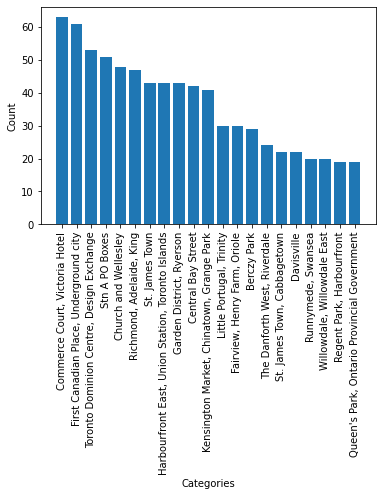

<Figure size 720x432 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
venues_count_neighborhood=all_venues.groupby('Neighborhood').count().sort_values(by='Venue',ascending=False)
neigh_names=venues_count_neighborhood.index[0:21]
counts=venues_count_neighborhood.Venue[0:21]
plt.bar(neigh_names,counts)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=90, horizontalalignment="center")
fig=plt.figure()
fig.set_size_inches(10,6)
plt.show()

<b> 2. Analyze categories of restaurants

<b> Report unique categories

In [21]:
print('There are {} uniques categories.'.format(len(all_venues['Venue Category'].unique())))

There are 76 uniques categories.


<b> Plot count of most common categories of restaurants 

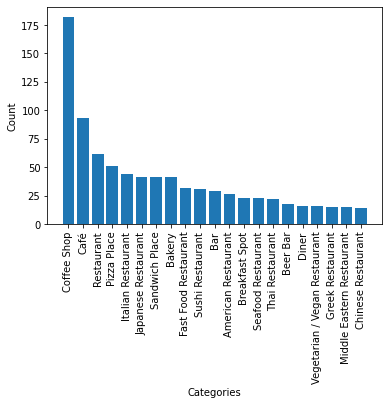

<Figure size 720x432 with 0 Axes>

In [22]:

all_venues.shape
venues_count=all_venues.groupby('Venue Category').count().sort_values(by='Venue',ascending=False)
categories=venues_count.index[0:21]
counts=venues_count.Venue[0:21]
plt.bar(categories,counts)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=90, horizontalalignment="center")
fig=plt.figure()
fig.set_size_inches(10,6)
plt.show()

<b> Use on-hot encoding on venue categories and create new data frame

In [25]:
# one hot encoding
all_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")
col_list=list(all_onehot.columns)

# add neighborhood column back to dataframe
all_onehot['Neighborhood'] = all_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + col_list
fixed_columns
all_onehot = all_onehot[fixed_columns]
all_onehot.head()

,Neighborhood,Airport Food Court,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Belgian Restaurant,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Gaming Cafe,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Health Food Store,Hookah Bar,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Sake Bar,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Sports Bar,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,"Regent Park, Harbourfront",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<b> Calculate mean value for each category for all neighborhoods

In [26]:
all_grouped = all_onehot.groupby('Neighborhood').mean().reset_index()
all_grouped.head()

,Neighborhood,Airport Food Court,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Belgian Restaurant,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Gaming Cafe,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Health Food Store,Hookah Bar,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Sake Bar,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Sports Bar,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Agincourt,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.000,0.000000,0.0000,0.0,0.0,0.5,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.250,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.5000,0.0,0.0,0.0000,0.0,0.0,0.250,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.250,0.0,0.0000,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.1250,0.0,0.0,0.1250,0.0,0.0,0.125,0.0,0.0,0.1250,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.333333,0.0,0.000,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.000,0.333333,0.0000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.000000,0.0,0.125,0.0,0.0625,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0625,0.125,0.000000,0.0625,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0625,0.0,0.0,0.125,0.0,0.0,0.0625,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
all_gp1=all_onehot.groupby('Neighborhood').count().reset_index()
counts=all_gp1.iloc[:,1]
all_grouped.insert(1,'Venues_count',counts)
all_grouped.head()

,Neighborhood,Venues_count,Airport Food Court,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Belgian Restaurant,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Gaming Cafe,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Health Food Store,Hookah Bar,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Sake Bar,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Sports Bar,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Agincourt,2,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.000,0.000000,0.0000,0.0,0.0,0.5,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",4,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.250,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.5000,0.0,0.0,0.0000,0.0,0.0,0.250,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",8,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.250,0.0,0.0000,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.1250,0.0,0.0,0.1250,0.0,0.0,0.125,0.0,0.0,0.1250,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,3,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.333333,0.0,0.000,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,0.000,0.333333,0.0000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.000,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",16,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.000000,0.0,0.125,0.0,0.0625,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0625,0.125,0.000000,0.0625,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0625,0.0,0.0,0.125,0.0,0.0,0.0625,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0


<b> Report top 5 venue categories in each neighborhood

In [28]:
num_top_venues = 6

for hood in all_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = all_grouped[all_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                             venue  freq
0                     Venues_count   2.0
1        Latin American Restaurant   0.5
2                   Breakfast Spot   0.5
3          New American Restaurant   0.0
4  Molecular Gastronomy Restaurant   0.0
5       Modern European Restaurant   0.0


----Alderwood, Long Branch----
                       venue  freq
0               Venues_count  4.00
1                Pizza Place  0.50
2             Sandwich Place  0.25
3                Coffee Shop  0.25
4                   Wine Bar  0.00
5  Middle Eastern Restaurant  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0               Venues_count  8.00
1                Coffee Shop  0.25
2           Sushi Restaurant  0.12
3  Middle Eastern Restaurant  0.12
4                      Diner  0.12
5                 Restaurant  0.12


----Bayview Village----
                             venue  freq
0                     Venues_count  3.00
1     

<b> Add top 10 most common categories in each neighborhood in a dataframe

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood','Venues_count']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = all_grouped['Neighborhood']
neighborhoods_venues_sorted['Venues_count'] = all_grouped['Venues_count']

for ind in np.arange(all_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(all_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,Venues_count,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,2,Latin American Restaurant,Breakfast Spot,Wine Shop,Eastern European Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Ethiopian Restaurant
1,"Alderwood, Long Branch",4,Pizza Place,Coffee Shop,Sandwich Place,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",8,Coffee Shop,Sushi Restaurant,Pizza Place,Diner,Restaurant,Middle Eastern Restaurant,Sandwich Place,Ethiopian Restaurant,Falafel Restaurant,Eastern European Restaurant
3,Bayview Village,3,Chinese Restaurant,Café,Japanese Restaurant,Wine Shop,Eastern European Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",16,Coffee Shop,Italian Restaurant,Sandwich Place,Indian Restaurant,American Restaurant,Juice Bar,Thai Restaurant,Sushi Restaurant,Greek Restaurant,Comfort Food Restaurant


In [31]:
neighborhoods_venues_sorted.shape

(81, 12)

<b> Split data into 2 clusters

In [47]:
# set number of clusters
kclusters = 2

all_grouped_clustering = all_grouped.drop('Neighborhood', 1)
#all_grouped_clustering = all_grouped.drop(['Neighborhood','Venues_count'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1])

<b> Add cluster labels for each neighborhood

In [48]:
# add clustering labels
#neighborhoods_venues_sorted=neighborhoods_venues_sorted.drop('Cluster Labels',1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

all_merged = neighborhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
all_merged = all_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

all_merged.head() # check the last columns!

,Borough,Neighborhood,Lattitude,Longitude,Cluster Labels,Venues_count,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,0.0,1.0,Food & Drink Shop,Wine Shop,Ethiopian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
1,North York,Victoria Village,43.725882,-79.315572,0.0,3.0,Coffee Shop,Pizza Place,Portuguese Restaurant,Dumpling Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,19.0,Coffee Shop,Bakery,Café,Breakfast Spot,French Restaurant,Italian Restaurant,Restaurant,Wine Shop,Beer Bar,Diner
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,2.0,Coffee Shop,Vietnamese Restaurant,Ethiopian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,19.0,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Café,Diner,Fast Food Restaurant,Bar,Beer Bar,Japanese Restaurant,Sandwich Place


In [49]:
all_merged=all_merged.dropna(subset=["Cluster Labels"], axis=0)
all_merged.shape

(82, 16)

<b> Display all clusters on map

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_merged['Lattitude'], all_merged['Longitude'], all_merged['Neighborhood'], all_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [42]:
all_merged.to_csv('NY_toronto_only_Rest_ignore_count.csv')

<b> Neighbourhoods in Cluster 0

In [54]:
label0=all_merged[all_merged['Cluster Labels'] == 0.0]
label0.reset_index(inplace=True)
print(label0.shape)
label0.head()

(68, 17)


,index,Borough,Neighborhood,Lattitude,Longitude,Cluster Labels,Venues_count,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,North York,Parkwoods,43.753259,-79.329656,0.0,1.0,Food & Drink Shop,Wine Shop,Ethiopian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
1,1,North York,Victoria Village,43.725882,-79.315572,0.0,3.0,Coffee Shop,Pizza Place,Portuguese Restaurant,Dumpling Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
2,2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,19.0,Coffee Shop,Bakery,Café,Breakfast Spot,French Restaurant,Italian Restaurant,Restaurant,Wine Shop,Beer Bar,Diner
3,3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,2.0,Coffee Shop,Vietnamese Restaurant,Ethiopian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,19.0,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Café,Diner,Fast Food Restaurant,Bar,Beer Bar,Japanese Restaurant,Sandwich Place


<b> Neighbourhoods in Cluster 1

In [55]:
label1=all_merged[all_merged['Cluster Labels'] == 1.0]
label1.reset_index(inplace=True)
print(label1.shape)
label1.head(5)

(14, 17)


,index,Borough,Neighborhood,Lattitude,Longitude,Cluster Labels,Venues_count,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,9,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1.0,43.0,Coffee Shop,Japanese Restaurant,Café,Middle Eastern Restaurant,Ramen Restaurant,Italian Restaurant,Fast Food Restaurant,Diner,Pizza Place,Mexican Restaurant
1,15,Downtown Toronto,St. James Town,43.651494,-79.375418,1.0,43.0,Coffee Shop,Café,American Restaurant,Cocktail Bar,Italian Restaurant,Seafood Restaurant,Restaurant,Beer Bar,Moroccan Restaurant,Japanese Restaurant
2,20,Downtown Toronto,Berczy Park,43.644771,-79.373306,1.0,29.0,Coffee Shop,Cocktail Bar,Restaurant,Bakery,Seafood Restaurant,Beer Bar,French Restaurant,Comfort Food Restaurant,Japanese Restaurant,Diner
3,24,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1.0,42.0,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Burger Joint,Falafel Restaurant,Restaurant,Juice Bar,Indian Restaurant,Korean Restaurant
4,30,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1.0,47.0,Coffee Shop,Café,Restaurant,Thai Restaurant,Sushi Restaurant,Bakery,Pizza Place,American Restaurant,Modern European Restaurant,New American Restaurant
